# Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

**План выполнения:**

1. Провести исследовательский анализ набора фотографий.
2. Подготовить данные к обучению (извлечение данных, аугментация, разделение на выборки).
3. Обучить нейронную сеть и рассчитать её качество.

# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import random
import seaborn as sns

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
from IPython.display import Markdown, display

In [2]:
def printmd(string):
    display(Markdown(string))

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [4]:

train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 


Found 7591 validated image filenames.


In [5]:
def data_info(df, datagen):
    """Функция первичного знакомства с данными"""
    display(df.head(10))
    printmd('**Общая информация:**')
    display(df.info())
    printmd('**Общая статистика:**')
    display(df.describe())
    printmd('**Дубликаты:**')
    display(df.duplicated().sum())
    printmd('**Пропуски:**')
    for col in df.columns:
        pct_missing = np.mean(df[col].isna())
        printmd('{} - {}%'.format(col, round(pct_missing*100,2)))
    printmd('**Гистограмма распределения возраста**')
    labels['real_age'].hist(bins=100)
    printmd('**Размер выборки:**')
    features, target = next(datagen)
    printmd(f'**Размер выборки признаков** {features.shape}')
    printmd(f'**Размер выборки целевых признаков** {target.shape}')
    # вывод 16-ти фотографий
    fig = plt.figure(figsize=(15,15))
    for i in range(0, 15):
        fig.add_subplot(5, 3, i+1)
        j = random.randint(0, len(datagen))
        generated_image = datagen[j][0][i]
        age = datagen[j][1][i]
        plt.imshow(generated_image)
        plt.title(f'Age {age}')
        plt.colorbar()
        plt.tight_layout()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


**Общая информация:**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

**Общая статистика:**

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


**Дубликаты:**

0

**Пропуски:**

file_name - 0.0%

real_age - 0.0%

**Гистограмма распределения возраста**

**Размер выборки:**

**Размер выборки признаков** (32, 224, 224, 3)

**Размер выборки целевых признаков** (32,)

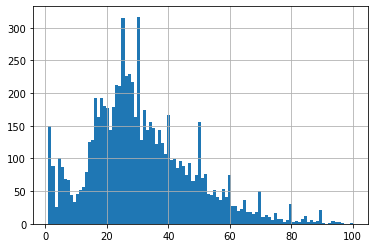

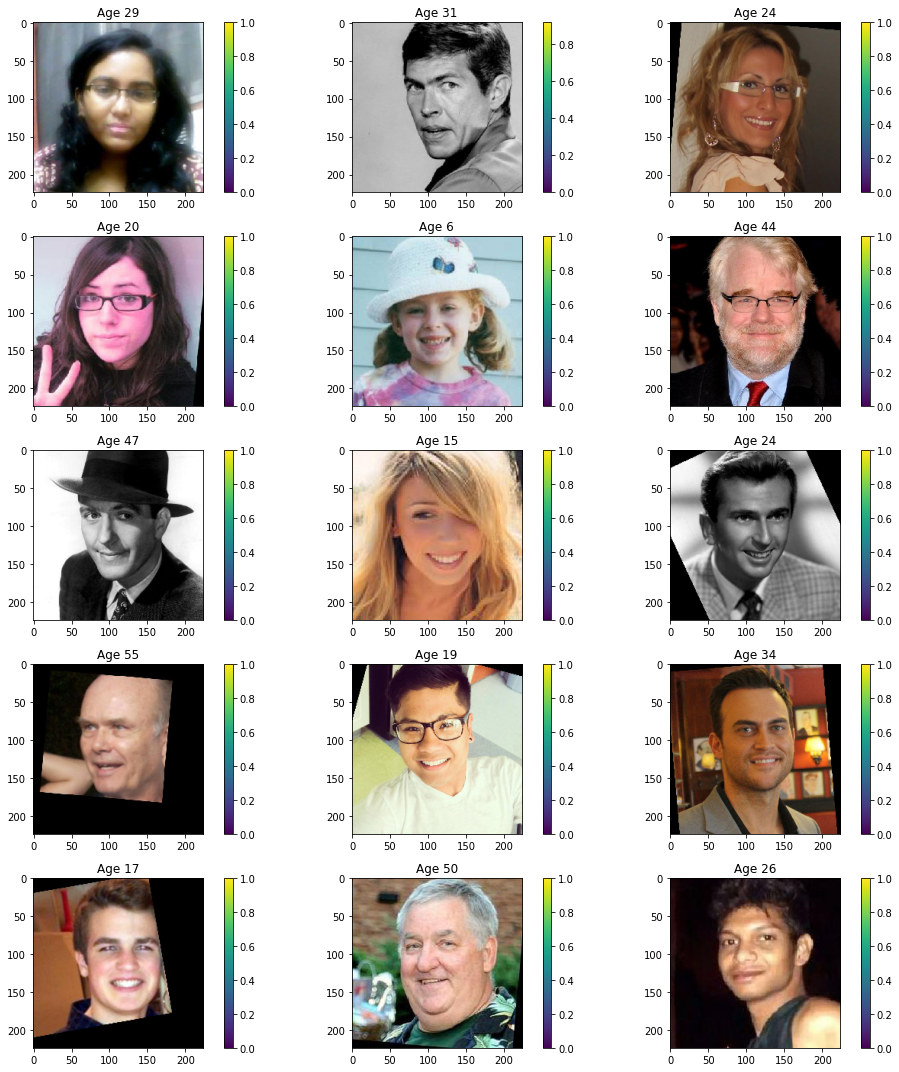

In [6]:
data_info(labels, train_gen_flow)

### Вывод

Наша выборка состоит и 7591 фотография разного формата и файл labels.csv который содержит в себе 2 колонки:
* file_name - %номер фотографии%.jpg
* real_age - возраст человека на фото

Распределение выборки стремится к нормальному:
* медиана - 29
* средняя - 31

В выборке замечено следующее:
* большое количество детей до 10 лет
* выбросы на круглых значениях

Некоторые фотографии имеют смещения и ротацию, это сделано для стандартизации положения голову в вертикальное положение. Так же присутствуют фотографии чёрно-белого цвета.

В связи с тем что в нашем распоряжении достаточно много данных для дообучения resnet50 часть сети не нуждается в заморозке.

Т.К. Данные фотографии имеют разный размер их необходимо будет стандартизировать по этому параметру

## Обучение модели

In [7]:
def load_train(path):
    
    data = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        vertical_flip=True,
        rescale=1/255.)
    
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = data,
        directory = path + 'final_files/',
        target_size=(224, 224),
        batch_size=32,
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        subset = 'training',
        seed=12345)
    
    return train_datagen_flow


In [8]:
def load_test(path):
    
    data = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.)
    
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = data,
        directory = path + 'final_files/',
        target_size=(224, 224),
        batch_size=32,
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        subset = 'validation',
        seed=12345)
    
    return test_datagen_flow


In [9]:
def create_model(input_shape):
    
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalMaxPooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
    return model

In [10]:
def train_model(model, train_data, test_data, batch_size=None, epochs=15,
                steps_per_epoch=None, validation_steps=None):
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
 
    return model

### Данные вывода при обучении модели

Train for 178 steps, validate for 60 steps
Epoch 1/15
2022-07-23 22:48:42.757641: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-07-23 22:48:45.010306: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 67s - loss: 178.5030 - mae: 9.9416 - val_loss: 966.8533 - val_mae: 26.3116
Epoch 2/15
178/178 - 37s - loss: 68.2488 - mae: 6.3307 - val_loss: 595.3477 - val_mae: 19.0263
Epoch 3/15
178/178 - 37s - loss: 48.9282 - mae: 5.2910 - val_loss: 390.1937 - val_mae: 14.9856
Epoch 4/15
178/178 - 37s - loss: 38.9113 - mae: 4.7247 - val_loss: 144.1960 - val_mae: 9.0384
Epoch 5/15
178/178 - 37s - loss: 29.8788 - mae: 4.1801 - val_loss: 101.3254 - val_mae: 7.5903
Epoch 6/15
178/178 - 37s - loss: 29.0663 - mae: 4.1250 - val_loss: 80.4441 - val_mae: 6.8087
Epoch 7/15
178/178 - 37s - loss: 27.1405 - mae: 4.0045 - val_loss: 79.4776 - val_mae: 6.9922
Epoch 8/15
178/178 - 37s - loss: 23.7568 - mae: 3.7224 - val_loss: 86.5340 - val_mae: 7.2750
Epoch 9/15
178/178 - 37s - loss: 23.3316 - mae: 3.6971 - val_loss: 103.4375 - val_mae: 7.6401
Epoch 10/15
178/178 - 37s - loss: 22.0006 - mae: 3.6025 - val_loss: 78.2182 - val_mae: 6.7734
Epoch 11/15
178/178 - 37s - loss: 20.5415 - mae: 3.4961 - val_loss: 72.5854 - val_mae: 6.4855
Epoch 12/15
178/178 - 37s - loss: 19.0723 - mae: 3.3520 - val_loss: 76.5627 - val_mae: 6.7973
Epoch 13/15
178/178 - 37s - loss: 16.9730 - mae: 3.1829 - val_loss: 86.4388 - val_mae: 6.8514
Epoch 14/15
178/178 - 37s - loss: 16.8814 - mae: 3.1717 - val_loss: 72.7784 - val_mae: 6.4641
Epoch 15/15
178/178 - 37s - loss: 16.8244 - mae: 3.1212 - val_loss: 78.8819 - val_mae: 6.8901
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 78.8819 - mae: 6.8901
Test MAE: 6.8901



### Анализ обученной модели

Была обучена модель для определения возраста покупателя на базе модели ResNet50 предобученной на наборе ImageNet. В качестве оптимизатора был применен алгаритм градиентного бустинга Adam с learning_rate = 0.0001. Функцией потерь в моделе выступает MAE.

В качестве аугментации были применены параметры отражения данных по вертикали, в связи с удовлетворяющим качеством модели смещения применены не были, а отражения по горизонтали не имеют смысла, т.к. в таком случае фотографии имели бы перевернутый вид, что противоречит ситуации в реальности.

Модель способна решать задачи:

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

Применение данных модели для определение добросоветсности кассиров при отпускании товаров 18+ является нецелесообразным, т.к. МАЕ  нашей модели составляет `6.8901` что неизбежно влечёт за собой сильный разброс и лица 18-ти летнего возраста могут идентифицироваться как 12-ти летние. Нужны способы увеличения точности модели.